In [1]:
!nvidia-smi

Wed Dec 15 07:29:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    41W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive._mount("/content/drive")

import os
os.chdir("/content/drive/My Drive/Computer Vision 2021")

!ls
!rm -rf /data
!mkdir /data
!cp val2017_custom2.zip /data

os.chdir("/data")
!ls

!unzip val2017_custom2.zip > /dev/null

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip
!cp annotations/instances_val2017.json .

!rm -rf annotations/
!rm *.zip

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 coco_custom2_yolo.zip
 COCO-val2014-BBox-Results.gsheet
'COCO YOLOv5 Results.gsheet'
 ensemble_20.pth
 ensemble_30.pth
 ensemble_focal_20.pth
 ensemble_focal_40.pth
 fcn_test_10.pth
 fcn_test_scratch_10.pth
 fcn_test_scratch_15.pth
 fcn_test_scratch_data_augment_20.pth
 fcn_test_scratch_data_augment_dice_loss_10.pth
 fcn_test_scratch_data_augment_focal_loss_10.pth
 fcn_test_scratch_data_augment_focal_loss_v2_10.pth
 fcn_test_scratch_data_augment_focal_loss_v2_20.pth
 fcn_test_scratch_data_augment_v2_10.pth
 fcn_test_scratch_data_augment_v2_20.pth
 fcn_test_scratch_v2_10.pth
'Final Project.gdoc'
'Final Report Draft.gdoc'
'Progress Report.gdoc'
'Project Proposal (Computer Vision 2021):.gdoc'
 segnet_20.pth
 segnet_30.pth
 segnet_40.pth
 segnet_60.pth
 segnet_focal_loss_10.pth
 segnet_focal_loss_40.pth
 segnet_focal_loss_60.pth
 segnet_test.pth
 train2017_custo

In [3]:
!df -h
import os
os.chdir("/data")
!ls

Filesystem      Size  Used Avail Use% Mounted on
overlay         167G   45G  123G  27% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  821M  59% /sbin/docker-init
tmpfs           6.4G   36K  6.4G   1% /var/colab
/dev/sda1       174G   50G  124G  29% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           167G   51G  116G  31% /content/drive
instances_val2017.json	val2017_custom_2


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

from pycocotools.coco import COCO

from PIL import Image

import numpy as np
import random

import os
import tqdm

import matplotlib
import matplotlib.pyplot as plt

!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

%matplotlib inline

cuda


In [5]:
CATEGORIES = [
            "airplane",
            "bicycle",
            "bird",
            "boat",
            "bottle",
            "bus",
            "car",
            "cat",
            "chair",
            "cow",
            "dining table",
            "dog",
            "horse",
            "motorcycle",
            "person",
            "potted plant",
            "sheep",
            "couch",
            "train",
            "tv"
        ]
CATEGORIES = sorted(CATEGORIES)

class CustomDataset(Dataset):

    def __init__(self, image_folder_path,
                       annotations_file,
                       augment=False):
        self.augment = augment
        self.image_folder_path = image_folder_path
        self.coco = COCO(annotations_file)

        self.image_ids = []
        for image_id in self.coco.imgs:
            fname = self.coco.imgs[image_id]["file_name"]
            fpath = os.path.join(image_folder_path, fname)

            if os.path.isfile(fpath):
                self.image_ids.append(image_id)

        categories = self.coco.loadCats(self.coco.getCatIds())

        category_names_to_ids = {}
        for c in categories:
            category_names_to_ids[c["name"]] = c["id"]

        self.category_ids = []
        for c in CATEGORIES:
            self.category_ids.append(category_names_to_ids[c])

        self.category_id_mapping = {}
        self.category_id_mapping[0] = 0
        for i in range(len(CATEGORIES)):
            self.category_id_mapping[category_names_to_ids[CATEGORIES[i]]] = i + 1

        print(category_names_to_ids)
        print(self.category_id_mapping)

        assert len(self.category_ids) == len(CATEGORIES), len(self.category_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        fname = self.coco.imgs[img_id]["file_name"]
        img_path = os.path.join(self.image_folder_path, fname)

        img = Image.open(img_path).convert("RGB")

        anns_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.category_ids, iscrowd=None)
        anns = self.coco.loadAnns(anns_ids)

        W, H = img.size
        mask = np.zeros((H, W))
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann) * self.category_id_mapping[ann["category_id"]])
        
        mask = torch.from_numpy(mask)

        img = TF.to_tensor(img)

        resize = transforms.Resize(size=(256, 256))
        img = resize(img)
        mask = resize(mask.unsqueeze(0)).squeeze()

        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = normalize(img)

        if self.augment:
          if random.random() > 0.5:
              img = TF.hflip(img)
              mask = TF.hflip(mask)

          if random.random() > 0.5:
              img = TF.vflip(img)
              mask = TF.vflip(mask)

        return img, mask

    def __len__(self):
        return len(self.image_ids)

In [6]:
val_dataset = CustomDataset(image_folder_path="/data/val2017_custom_2", annotations_file="/data/instances_val2017.json")

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!
{'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'l

In [38]:
BATCH_SIZE = 128

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

def show_images(img, label, prediction=None):
  if prediction is not None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  else:
    fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.imshow(img.cpu().squeeze().permute(1, 2, 0))
  ax1.set_title("Input image")

  _, W, H = img.size()

  r = Image.fromarray(label.byte().cpu().numpy()).resize((W, H))
  r.putpalette(colors)
  ax2.imshow(r)
  ax2.set_title("Ground truth")

  if prediction is not None:
    r = Image.fromarray(prediction.byte().cpu().numpy()).resize((W, H))
    r.putpalette(colors)
    ax3.imshow(r)
    ax3.set_title("Prediction")
  plt.show()

In [9]:
class SegNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, downsample=True, is_last_layer=False):
    super(SegNetBlock, self).__init__()
    self.downsample = downsample
    self.is_last_layer = is_last_layer

    if downsample:
      self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
    else:
      self.conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)

    if not is_last_layer:
      self.bn = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.conv(x)
    if not self.is_last_layer:
      x = self.bn(x)
    return x

  def init_weights(self, vgg_layer=None):
    if self.downsample:
      assert vgg_layer is not None
      self.conv.weight.data = vgg_layer.weight.data
      self.conv.bias.data = vgg_layer.bias.data
    else:
      nn.init.kaiming_normal(self.conv.weight)
      self.conv.bias.data.zero_()

    if not self.is_last_layer:
      self.bn.weight.data.fill_(1)
      self.bn.bias.data.zero_()

class SegNet(nn.Module):
  def __init__(self, num_classes=21):
    super(SegNet, self).__init__()
    
    self.down1a = SegNetBlock(3, 64)
    self.down1b = SegNetBlock(64, 64)

    self.down2a = SegNetBlock(64, 128)
    self.down2b = SegNetBlock(128, 128)

    self.down3a = SegNetBlock(128, 256)
    self.down3b = SegNetBlock(256, 256)
    self.down3c = SegNetBlock(256, 256)

    self.down4a = SegNetBlock(256, 512)
    self.down4b = SegNetBlock(512, 512)
    self.down4c = SegNetBlock(512, 512)

    self.down5a = SegNetBlock(512, 512)
    self.down5b = SegNetBlock(512, 512)
    self.down5c = SegNetBlock(512, 512)

    self.max_pool2d = lambda x: F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)

    self.up1a = SegNetBlock(512, 512, downsample=False)
    self.up1b = SegNetBlock(512, 512, downsample=False)
    self.up1c = SegNetBlock(512, 512, downsample=False)

    self.up2a = SegNetBlock(512, 512, downsample=False)
    self.up2b = SegNetBlock(512, 512, downsample=False)
    self.up2c = SegNetBlock(512, 256, downsample=False)

    self.up3a = SegNetBlock(256, 256, downsample=False)
    self.up3b = SegNetBlock(256, 256, downsample=False)
    self.up3c = SegNetBlock(256, 128, downsample=False)

    self.up4a = SegNetBlock(128, 128, downsample=False)
    self.up4b = SegNetBlock(128, 64, downsample=False)

    self.up5a = SegNetBlock(64, 64, downsample=False)
    self.up5b = SegNetBlock(64, num_classes, downsample=False, is_last_layer=True)

    self.max_unpool2d = lambda x, indices, output_size: F.max_unpool2d(x, indices, kernel_size=2, stride=2, output_size=output_size)

    self.init_weights()
  
  def forward(self, x):
    sizes = []
    pooling_indices = []

    sizes.append(x.size())
    x = F.relu(self.down1a(x))
    x = F.relu(self.down1b(x))
    x, indices = self.max_pool2d(x)
    pooling_indices.append(indices)

    sizes.append(x.size())
    x = F.relu(self.down2a(x))
    x = F.relu(self.down2b(x))
    x, indices = self.max_pool2d(x)
    pooling_indices.append(indices)

    sizes.append(x.size())
    x = F.relu(self.down3a(x))
    x = F.relu(self.down3b(x))
    x = F.relu(self.down3c(x))
    x, indices = self.max_pool2d(x)
    pooling_indices.append(indices)

    sizes.append(x.size())
    x = F.relu(self.down4a(x))
    x = F.relu(self.down4b(x))
    x = F.relu(self.down4c(x))
    x, indices = self.max_pool2d(x)
    pooling_indices.append(indices)

    sizes.append(x.size())
    x = F.relu(self.down5a(x))
    x = F.relu(self.down5b(x))
    x = F.relu(self.down5c(x))
    x, indices = self.max_pool2d(x)
    pooling_indices.append(indices)

    x = self.max_unpool2d(x, pooling_indices.pop(), sizes.pop())
    x = F.relu(self.up1a(x))
    x = F.relu(self.up1b(x))
    x = F.relu(self.up1c(x))

    x = self.max_unpool2d(x, pooling_indices.pop(), sizes.pop())
    x = F.relu(self.up2a(x))
    x = F.relu(self.up2b(x))
    x = F.relu(self.up2c(x))

    x = self.max_unpool2d(x, pooling_indices.pop(), sizes.pop())
    x = F.relu(self.up3a(x))
    x = F.relu(self.up3b(x))
    x = F.relu(self.up3c(x))

    x = self.max_unpool2d(x, pooling_indices.pop(), sizes.pop())
    x = F.relu(self.up4a(x))
    x = F.relu(self.up4b(x))

    x = self.max_unpool2d(x, pooling_indices.pop(), sizes.pop())
    x = F.relu(self.up5a(x))
    x = self.up5b(x)

    return x

  def init_weights(self):
    vgg16 = torchvision.models.vgg16(pretrained=True)

    self.down1a.init_weights(vgg16.features[0])
    self.down1b.init_weights(vgg16.features[2])

    self.down2a.init_weights(vgg16.features[5])
    self.down2b.init_weights(vgg16.features[7])

    self.down3a.init_weights(vgg16.features[10])
    self.down3b.init_weights(vgg16.features[12])
    self.down3c.init_weights(vgg16.features[14])

    self.down4a.init_weights(vgg16.features[17])
    self.down4b.init_weights(vgg16.features[19])
    self.down4c.init_weights(vgg16.features[21])

    self.down5a.init_weights(vgg16.features[24])
    self.down5b.init_weights(vgg16.features[26])
    self.down5c.init_weights(vgg16.features[28])

    self.up1a.init_weights()
    self.up1b.init_weights()
    self.up1c.init_weights()

    self.up2a.init_weights()
    self.up2b.init_weights()
    self.up2c.init_weights()

    self.up3a.init_weights()
    self.up3b.init_weights()
    self.up3c.init_weights()

    self.up4a.init_weights()
    self.up4b.init_weights()

    self.up5a.init_weights()
    self.up5b.init_weights()

In [21]:
class EnsembleModel(nn.Module):

  def __init__(self, num_classes=21):
    super(EnsembleModel, self).__init__()
    self.unet = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=num_classes)
    self.segnet = SegNet(num_classes)

  def forward(self, x):
    segnet_out = self.segnet(x)
    unet_out = self.unet(x)

    return segnet_out + unet_out

In [10]:
# From https://github.com/kevinzakka/pytorch-goodies/blob/master/metrics.py

def nanmean(x):
    """Computes the arithmetic mean ignoring any NaNs."""
    return torch.mean(x[x == x])

EPS = 1e-10


def _fast_hist(true, pred, num_classes):
    mask = (true >= 0) & (true < num_classes)
    hist = torch.bincount(
        num_classes * true[mask] + pred[mask],
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()
    return hist

def overall_pixel_accuracy(hist):
    correct = torch.diag(hist).sum()
    total = hist.sum()
    overall_acc = correct / (total + EPS)
    return overall_acc

def per_class_pixel_accuracy(hist):
    correct_per_class = torch.diag(hist)
    total_per_class = hist.sum(dim=1)
    per_class_acc = correct_per_class / (total_per_class + EPS)
    avg_per_class_acc = nanmean(per_class_acc)
    return avg_per_class_acc

def eval_metrics(true, pred, num_classes):
    hist = torch.zeros((num_classes, num_classes), device=device)
    for t, p in zip(true, pred):
        hist += _fast_hist(t.flatten(), p.flatten(), num_classes)
    overall_acc = overall_pixel_accuracy(hist)
    avg_per_class_acc = per_class_pixel_accuracy(hist)
    return overall_acc, avg_per_class_acc

In [39]:
def load_state(name, model, folder="/content/drive/My Drive/Computer Vision 2021"):
  path = os.path.join(folder, name)
  state = torch.load(path)
  model.load_state_dict(state["model_state_dict"])
  return state["epoch"], state["loss"]

def evaluate(model, validation_dataloader, postprocess=None):
  model.eval()
  rv = 0

  overall_accs = []
  per_class_accs = []

  with torch.no_grad():
    for i, (imgs, labels) in tqdm.tqdm(enumerate(validation_dataloader), total=len(validation_dataloader)):
      imgs = imgs.to(device)
      labels = labels.type(torch.LongTensor).to(device)
      
      predictions = model(imgs)
      if postprocess:
        predictions = postprocess(predictions)
      
      overall_acc, per_class_acc = eval_metrics(labels, predictions.argmax(1), 21)
      overall_accs.append(overall_acc.item())
      per_class_accs.append(per_class_acc.item())

      del predictions
      del imgs
      del labels
      del overall_acc
      del per_class_acc

  return sum(overall_accs) / len(overall_accs), sum(per_class_accs) / len(per_class_accs)


def visualization(model, validation_dataloader, postprocess=None):
  model.eval()
  with torch.no_grad():
    for i, (imgs, labels) in tqdm.tqdm(enumerate(validation_dataloader), total=len(validation_dataloader)):
      imgs = imgs.to(device)
      labels = labels.type(torch.LongTensor).to(device)
      
      predictions = model(imgs)
      if postprocess:
        predictions = postprocess(predictions)
      
      if i % 5 == 0:
        show_images(imgs[0], labels[0], predictions[0].argmax(0))

      del predictions
      del imgs
      del labels

In [12]:
u_net = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=21)
u_net = u_net.to(device)
_ = load_state("unet_60.pth", u_net)
acc = evaluate(u_net, val_dataloader)
print(acc)

100%|██████████| 24/24 [01:22<00:00,  3.45s/it]

(0.8400486012299856, 0.42382159767051536)


  0%|          | 0/24 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


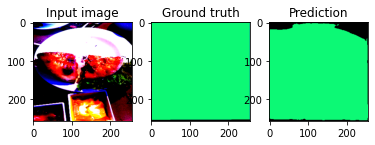

 21%|██        | 5/24 [00:17<01:06,  3.49s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


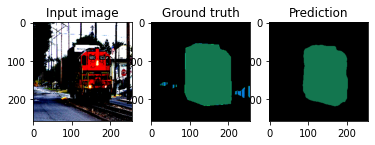

 42%|████▏     | 10/24 [00:31<00:41,  2.95s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


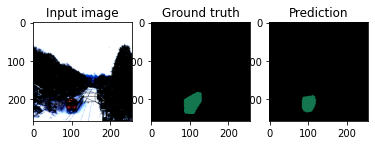

 62%|██████▎   | 15/24 [00:47<00:26,  2.97s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


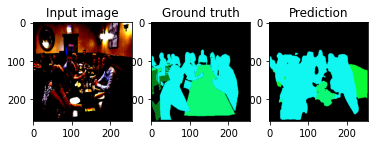

 83%|████████▎ | 20/24 [01:01<00:11,  2.84s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


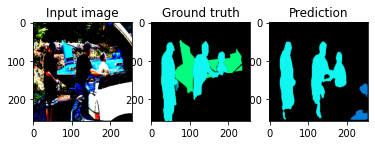

100%|██████████| 24/24 [01:11<00:00,  2.97s/it]


In [40]:
visualization(u_net, val_dataloader)

In [13]:
u_net_focal = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=21)
u_net_focal = u_net_focal.to(device)
_ = load_state("unet_focal_60.pth", u_net_focal)
acc = evaluate(u_net_focal, val_dataloader)
print(acc)

100%|██████████| 24/24 [01:16<00:00,  3.19s/it]

(0.8317091638843218, 0.413667019456625)


  0%|          | 0/24 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


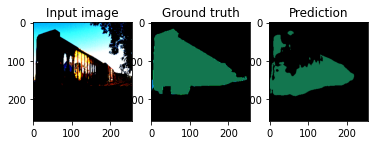

 21%|██        | 5/24 [00:15<00:56,  2.95s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


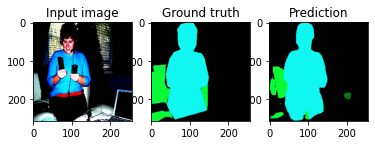

 42%|████▏     | 10/24 [00:30<00:42,  3.00s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


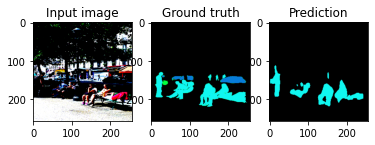

 62%|██████▎   | 15/24 [00:46<00:27,  3.04s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


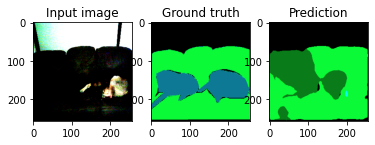

 83%|████████▎ | 20/24 [01:00<00:11,  2.93s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


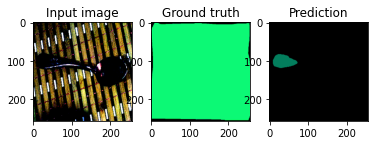

100%|██████████| 24/24 [01:11<00:00,  2.96s/it]


In [41]:
visualization(u_net_focal, val_dataloader)

In [14]:
segnet = SegNet(21)
segnet = segnet.to(device)
_ = load_state("segnet_60.pth", segnet)
acc = evaluate(segnet, val_dataloader)
print(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
100%|██████████| 24/24 [01:33<00:00,  3.88s/it]

(0.8240339184800783, 0.37834120479722816)


  0%|          | 0/24 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


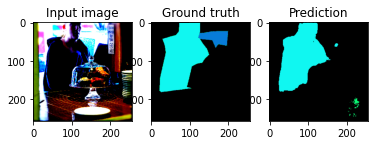

 21%|██        | 5/24 [00:15<00:56,  2.95s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


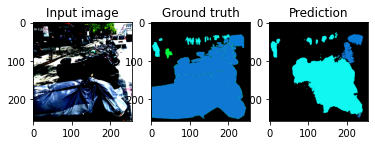

 42%|████▏     | 10/24 [00:31<00:41,  2.95s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


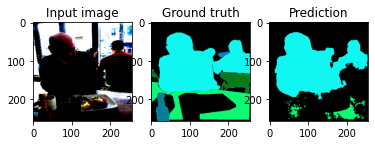

 62%|██████▎   | 15/24 [00:47<00:27,  3.10s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


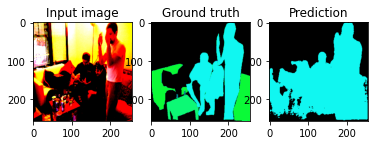

 83%|████████▎ | 20/24 [01:09<00:15,  3.98s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


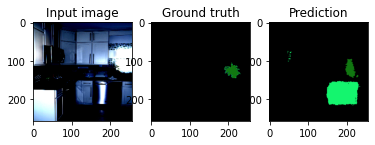

100%|██████████| 24/24 [01:23<00:00,  3.49s/it]


In [42]:
visualization(segnet, val_dataloader)

In [15]:
segnet_focal = SegNet(21)
segnet_focal = segnet_focal.to(device)
_ = load_state("segnet_focal_loss_60.pth", segnet_focal)
acc = evaluate(segnet_focal, val_dataloader)
print(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
100%|██████████| 24/24 [01:36<00:00,  4.00s/it]

(0.8086712236205736, 0.35971706733107567)


  0%|          | 0/24 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


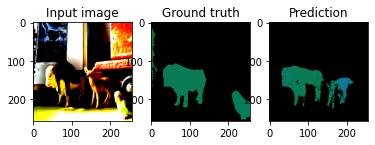

 21%|██        | 5/24 [00:18<01:03,  3.33s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


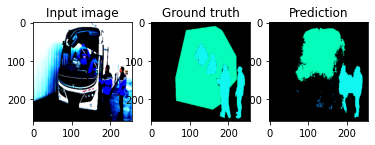

 42%|████▏     | 10/24 [00:34<00:42,  3.05s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


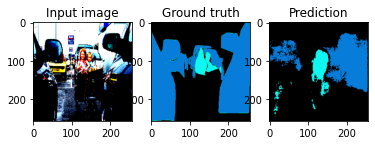

 62%|██████▎   | 15/24 [00:50<00:27,  3.01s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


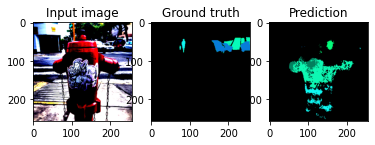

 83%|████████▎ | 20/24 [01:07<00:12,  3.14s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


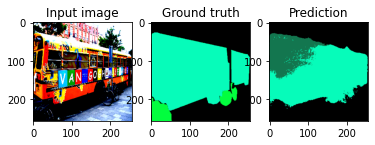

100%|██████████| 24/24 [01:18<00:00,  3.26s/it]


In [43]:
visualization(segnet_focal, val_dataloader)

In [18]:
fcn_pretrained = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
fcn_pretrained = fcn_pretrained.to(device)
acc = evaluate(fcn_pretrained, val_dataloader, postprocess = lambda output: output["out"])
print(acc)

100%|██████████| 24/24 [01:34<00:00,  3.95s/it]

(0.7484077562888464, 0.32950495680173236)


In [22]:
ensemble = EnsembleModel(21)
ensemble = ensemble.to(device)
_ = load_state("ensemble_30.pth", ensemble)
acc = evaluate(ensemble, val_dataloader)
print(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
100%|██████████| 24/24 [01:40<00:00,  4.17s/it]

(0.8364535644650459, 0.417819165935119)


  0%|          | 0/24 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


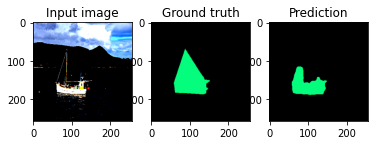

 21%|██        | 5/24 [00:16<00:59,  3.11s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


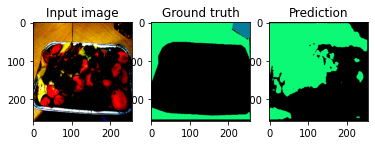

 42%|████▏     | 10/24 [00:33<00:43,  3.12s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


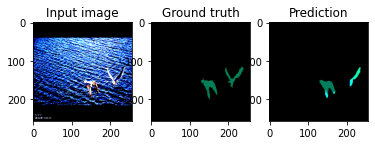

 62%|██████▎   | 15/24 [00:49<00:27,  3.05s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


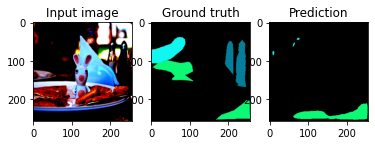

 83%|████████▎ | 20/24 [01:06<00:12,  3.21s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


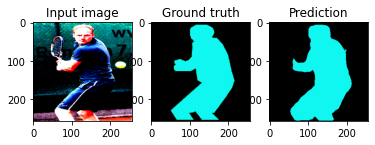

100%|██████████| 24/24 [01:18<00:00,  3.28s/it]


In [44]:
visualization(ensemble, val_dataloader)

In [34]:
ensemble_focal = EnsembleModel(21)
ensemble_focal = ensemble_focal.to(device)
_ = load_state("ensemble_focal_40.pth", ensemble_focal)
acc = evaluate(ensemble_focal, val_dataloader)
print(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
100%|██████████| 24/24 [01:45<00:00,  4.42s/it]

(0.8285722409685453, 0.3984737979869048)


  0%|          | 0/24 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


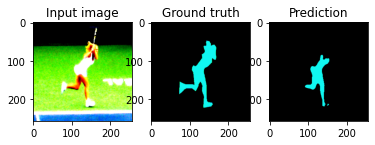

 21%|██        | 5/24 [00:16<00:59,  3.13s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


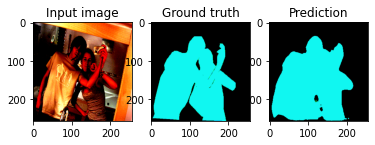

 42%|████▏     | 10/24 [00:32<00:42,  3.00s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


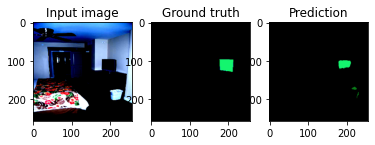

 62%|██████▎   | 15/24 [00:49<00:27,  3.06s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


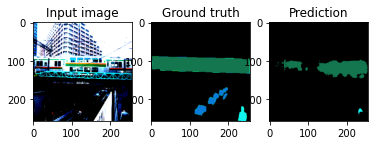

 83%|████████▎ | 20/24 [01:05<00:12,  3.14s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


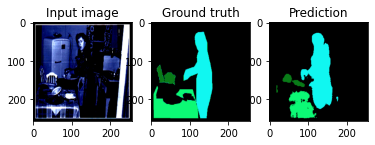

100%|██████████| 24/24 [01:17<00:00,  3.24s/it]


In [45]:
visualization(ensemble_focal, val_dataloader)

In [30]:
ensemble_separate = EnsembleModel(21)
ensemble_separate = ensemble_separate.to(device)
_ = load_state("unet_60.pth", ensemble_separate.unet)
_ = load_state("segnet_60.pth", ensemble_separate.segnet)
acc = evaluate(ensemble_separate, val_dataloader, postprocess = lambda output: output / 2)
print(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
100%|██████████| 24/24 [01:48<00:00,  4.50s/it]

(0.8474435781439146, 0.4013339305917422)


  0%|          | 0/24 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


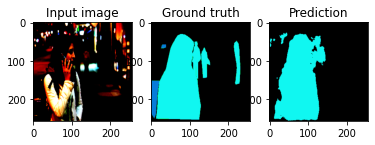

 21%|██        | 5/24 [00:16<00:58,  3.07s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


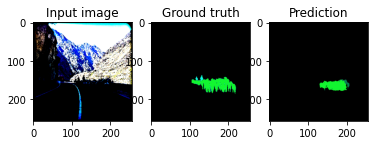

 42%|████▏     | 10/24 [00:32<00:42,  3.07s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


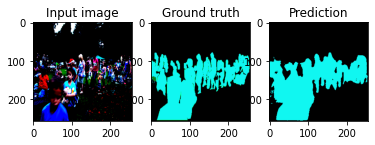

 62%|██████▎   | 15/24 [00:48<00:27,  3.08s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


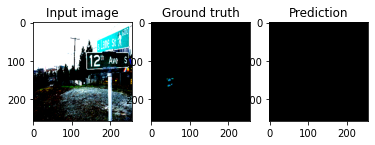

 83%|████████▎ | 20/24 [01:05<00:12,  3.06s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


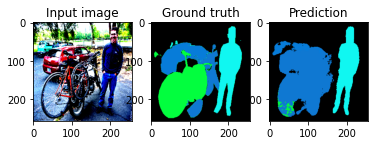

100%|██████████| 24/24 [01:17<00:00,  3.22s/it]


In [46]:
visualization(ensemble_separate, val_dataloader)

In [32]:
ensemble_separate_focal = EnsembleModel(21)
ensemble_separate_focal = ensemble_separate_focal.to(device)
_ = load_state("unet_focal_60.pth", ensemble_separate_focal.unet)
_ = load_state("segnet_focal_loss_60.pth", ensemble_separate_focal.segnet)
acc = evaluate(ensemble_separate_focal, val_dataloader, postprocess = lambda output: output / 2)
print(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
100%|██████████| 24/24 [01:46<00:00,  4.43s/it]

(0.8369840085506439, 0.3840021186818679)


  0%|          | 0/24 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


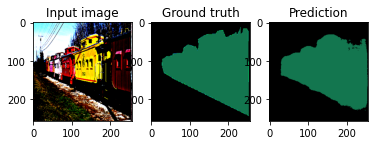

 21%|██        | 5/24 [00:16<00:57,  3.00s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


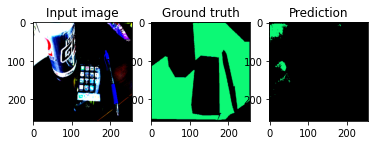

 42%|████▏     | 10/24 [00:32<00:42,  3.00s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


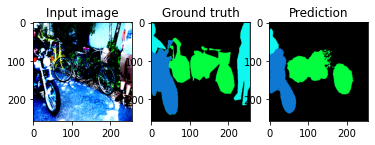

 62%|██████▎   | 15/24 [00:48<00:26,  2.98s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


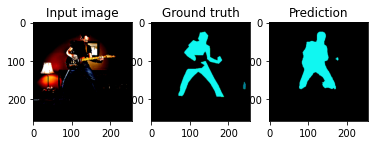

 83%|████████▎ | 20/24 [01:04<00:12,  3.08s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


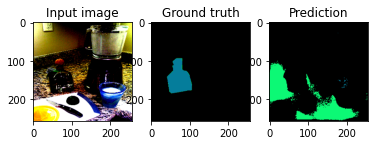

100%|██████████| 24/24 [01:16<00:00,  3.20s/it]


In [47]:
visualization(ensemble_separate_focal, val_dataloader)

In [26]:
fcn_trained = torchvision.models.segmentation.fcn_resnet50(pretrained=False)
_ = load_state("fcn_test_scratch_data_augment_v2_20.pth", fcn_trained)
fcn_trained = fcn_trained.to(device)
acc = evaluate(fcn_trained, val_dataloader, postprocess = lambda output: output["out"])
print(acc)

100%|██████████| 24/24 [01:34<00:00,  3.95s/it]

(0.838997575143973, 0.46892303104201954)


  0%|          | 0/24 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


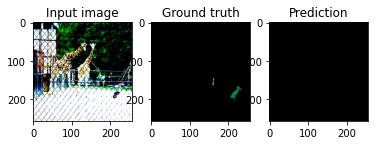

 21%|██        | 5/24 [00:15<00:56,  2.99s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


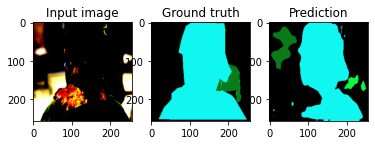

 42%|████▏     | 10/24 [00:32<00:43,  3.11s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


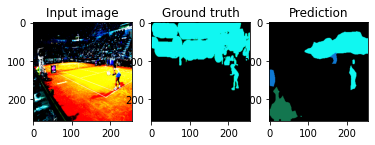

 62%|██████▎   | 15/24 [00:48<00:28,  3.15s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


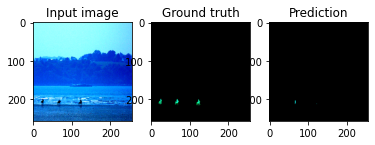

 83%|████████▎ | 20/24 [01:05<00:13,  3.31s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


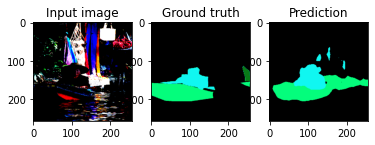

100%|██████████| 24/24 [01:17<00:00,  3.24s/it]


In [55]:
visualization(fcn_trained, val_dataloader, postprocess = lambda output: output["out"])

In [50]:
fcn_focal = torchvision.models.segmentation.fcn_resnet50(pretrained=False)
_ = load_state("fcn_test_scratch_data_augment_focal_loss_v2_20.pth", fcn_focal)
fcn_focal = fcn_focal.to(device)
acc = evaluate(fcn_focal, val_dataloader, postprocess = lambda output: output["out"])
print(acc)

 21%|██        | 5/24 [00:21<01:20,  4.22s/it]


KeyboardInterrupt: ignored

  0%|          | 0/24 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


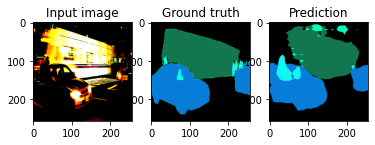

 21%|██        | 5/24 [00:16<00:59,  3.11s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


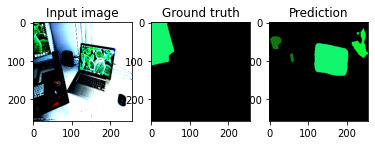

 42%|████▏     | 10/24 [00:33<00:44,  3.19s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


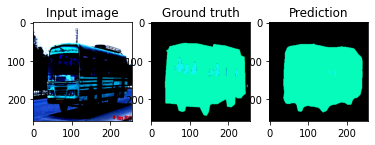

 62%|██████▎   | 15/24 [00:48<00:26,  2.93s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


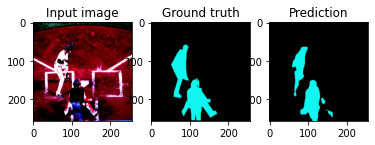

 83%|████████▎ | 20/24 [01:04<00:12,  3.07s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


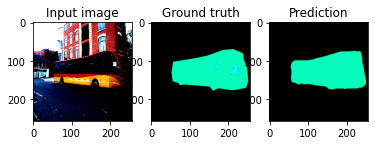

100%|██████████| 24/24 [01:16<00:00,  3.19s/it]


In [56]:
visualization(fcn_focal, val_dataloader, postprocess = lambda output: output["out"])